This demo program solves the Biharmonic equation,

$$\nabla^4 u(x, y) = f(x, y)$$

on the unit square with source f given by

$$f(x, y) = 4 \pi^4 \sin(\pi x) \sin(\pi y)$$

and boundary conditions given by

$$u(x, y)         = 0$$
$$\nabla^2 u(x, y) = 0$$

using a discontinuous Galerkin formulation (interior penalty method).

In [48]:
# Copyright (C) 2009 Kristian B. Oelgaard
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.
#
# Modified by Anders Logg, 2011
#
# First added:  2009-06-26
# Last changed: 2012-11-12

# Begin demo

from dolfin import *
%matplotlib inline

# Optimization options for the form compiler
# MBD: Disable these until I've finished optimizedquadraturetransformer.py
#parameters["form_compiler"]["cpp_optimize"] = True
#parameters["form_compiler"]["optimize"] = True

# Make mesh ghosted for evaluation of DG terms
parameters["ghost_mode"] = "shared_facet"

def biharmonic(V):
    """V: FunctionSpace."""
    
    # Create mesh and define function space
    mesh = V.mesh()

    # Define Dirichlet boundary
    class DirichletBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary

    class Source(Expression):
        def eval(self, values, x):
            values[0] = 4.0*pi**4*sin(pi*x[0])*sin(pi*x[1])

    # Define boundary condition
    u0 = project(Constant(0.0), V)  # MBD: Need this for Hermite (interpolation doesn't work)
    bc = DirichletBC(V, u0, DirichletBoundary())

    # Define trial and test functions
    u = TrialFunction(V)
    v = TestFunction(V)

    # Define normal component, mesh size and right-hand side
    h = CellSize(mesh)
    h_avg = (h('+') + h('-'))/2.0
    n = FacetNormal(mesh)
    f = Source(degree=3)

    # Penalty parameter
    alpha = Constant(8.0)

    # Define bilinear form
    a = inner(div(grad(u)), div(grad(v)))*dx \
      - inner(avg(div(grad(u))), jump(grad(v), n))*dS \
      - inner(jump(grad(u), n), avg(div(grad(v))))*dS \
      + alpha/h_avg*inner(jump(grad(u),n), jump(grad(v),n))*dS

    # Define linear form
    L = f*v*dx
    
    # Solve variational problem
    u = Function(V)
    #%debug -b /home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py:347 solve(a == L, u, bc)
    solve(a == L, u, bc)
    
    return u

## Results

In [49]:
W = FunctionSpace(UnitSquareMesh(32, 32), "Lagrange", 3)
good = biharmonic(W)

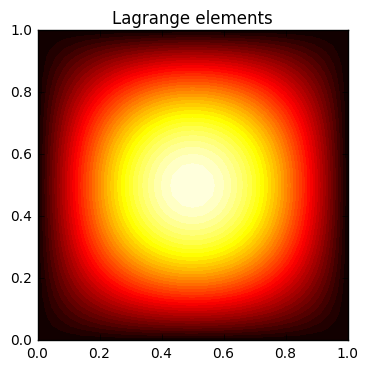

In [61]:
_ = plot(good, title="Lagrange elements", cmap='hot')

In [51]:
V = FunctionSpace(UnitSquareMesh(32, 32), "Hermite", 3)
bad = biharmonic(V)

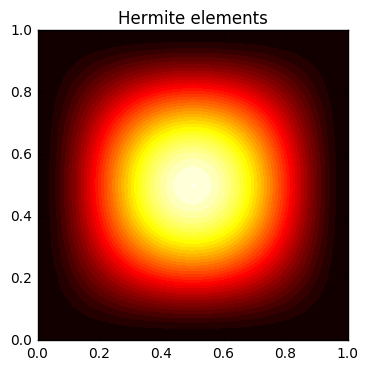

In [60]:
_ = plot(bad, title="Hermite elements", cmap='hot')

In [53]:
good.vector().min(), good.vector().max(), bad.vector().min(), bad.vector().max()

(0.0, 1.0000000449860573, -1.1029837326450256, 1.1029664848355063)

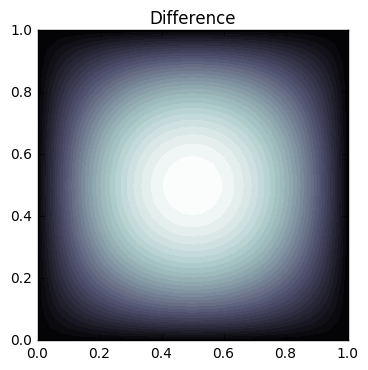

In [62]:
z = project(good-bad, V)
_ = plot(z, title="Difference", cmap='bone')

In [63]:
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np

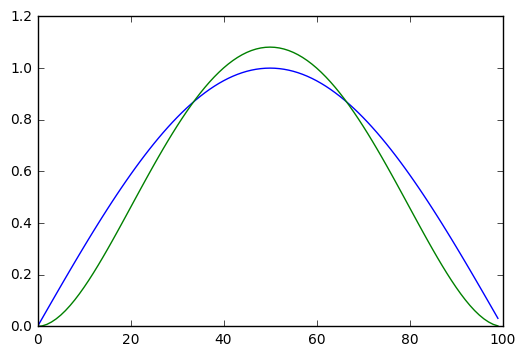

In [64]:
y = 0.5
xx = np.arange(0, 1, 0.01)
_ = pl.plot([good(x, y) for x in xx])
_ = pl.plot([bad(x, y )*3 for x in xx])
#_ = pl.plot([z(x, y) for x in xx])

In [ ]:
# Save solution to file
file = File("biharmonic-hermite.pvd")
file << bad

In [ ]:
#file = File("biharmonic-lagrange.pvd")
file << good